In [ ]:
! pip install bigartm

import artm
import json 
import pandas as pd
import numpy as np
import bz2
import os
from sklearn.metrics import f1_score, accuracy_score
import shutil

%matplotlib inline
from matplotlib import pyplot as plt

     |████████████████████████████████| 1.9MB 5.9MB/s 


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
with bz2.BZ2File(os.path.join('/content/gdrive/My Drive/lemmatized_wo_stopwords/train.bz2'), "r") as f:
    df_train = pd.read_json(f, lines=True)
    
with bz2.BZ2File(os.path.join('/content/gdrive/My Drive/lemmatized_wo_stopwords/test.bz2'), "r") as f:
    df_test = pd.read_json(f, lines=True)

In [ ]:
#vowpal wabbit формат данных (https://bigartm.readthedocs.io/en/stable/tutorials/datasets.html)

def df_to_vw(df, output_file):
    with open(output_file, 'w') as f:
        for idx, row in df.iterrows():
            tokens, counts = np.unique(row.text.split(), return_counts=True)
            line = '{} |@tokens '.format(str(idx)) + ' '.join(
                    ['{}:{}'.format(t, str(c)) for t, c in zip(tokens, counts)]
                ) + ' |@labels_class {}\n'.format(str(row.label))
            f.write(line)
            
def clean_folders():
    if os.path.exists('./test.txt'): os.remove('./test.txt')
    if os.path.exists('./train.txt'): os.remove('./train.txt')
    shutil.rmtree('./batches_train/', ignore_errors=True)
    shutil.rmtree('./batches_test/', ignore_errors=True)
    if os.path.exists('./vocab.txt'): os.remove('./vocab.txt')

def df_to_y_pred(df_train, df_test, seed=42):
    clean_folders()
    df_to_vw(df_test, './test.txt')
    df_to_vw(df_train, './train.txt')
    batch_vectorizer = artm.BatchVectorizer(data_path='train.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='./batches_train')
    batch_vectorizer_test = artm.BatchVectorizer(data_path='test.txt',
                                            data_format='vowpal_wabbit',
                                            target_folder='./batches_test')
    dictionary = artm.Dictionary()
    dictionary.gather(data_path='./batches_train')
    dictionary.save_text('./vocab.txt')
    model = artm.ARTM(num_topics=8, class_ids={'@tokens': 1.0, '@labels_class': 5.0}, 
                      seed=seed, num_document_passes=10)
    model.initialize(dictionary)
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
    theta_test = model.transform(batch_vectorizer=batch_vectorizer_test)
    theta_test = theta_test.reindex(sorted(theta_test.columns), axis=1)
    p_cd_test = model.transform(batch_vectorizer=batch_vectorizer_test, predict_class_id='@labels_class')
    p_cd_test = p_cd_test.reindex(sorted(p_cd_test.columns), axis=1)
    y_pred = p_cd_test.idxmax(axis=0).astype(int)
    model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      dictionary=dictionary))
    return y_pred

In [ ]:
clean_folders()
df_to_vw(df_test, './test.txt')
df_to_vw(df_train, './train.txt')

In [ ]:
y_pred = df_to_y_pred(df_train, df_test)
print('Accuracy: {}, F1(micro): {}, F1(macro): {}'.format(
    accuracy_score(y_pred, df_test.label.values), 
    f1_score(y_pred, df_test.label.values, average='micro'), 
    f1_score(y_pred, df_test.label.values, average='macro')))

Accuracy: 0.8725445408862494, F1(micro): 0.8725445408862494, F1(macro): 0.3852156780199103


# Кластеризация

In [ ]:
! pip install fasttext

     |████████████████████████████████| 71kB 3.4MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3039131 sha256=f64eb398666a16b23bab2720164e1298d07317e4c66119ff622c6e7b88df6443
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [ ]:
#предобученные эмбеддинги слов размерности 300

import fasttext.util

fasttext.util.download_model('en', if_exists='ignore')  #English
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
! pip install scikit-learn-extra

     |████████████████████████████████| 624kB 5.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp36-cp36m-linux_x86_64.whl size=339580 sha256=359972acc40fb3cba560aec1f4e5ad21a7a3a9edbff50c363a4d83207462e78f
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


In [ ]:
from sklearn_extra.cluster import KMedoids

def get_embedding_matrix(text):
    return np.array([ft.get_word_vector(word) for word in text.split()])

def get_embedding_matrix_from_df_new(df):
    words = []
    for idx, row in df.iterrows():
        words += row.text.split()
    words, counts = np.unique(words, return_counts=True)
    features = np.array(list(map(ft.get_word_vector, words)))
    return features, np.array(words), counts

In [ ]:
def get_metrics(y_pred, df_test):
    return accuracy_score(y_pred, df_test.label.values
            ), f1_score(y_pred, df_test.label.values, average='micro'
            ), f1_score(y_pred, df_test.label.values, average='macro')

def generate_new_text(km, words, text):
    return ' '.join(words[km.medoid_indices_[km.predict(get_embedding_matrix(text))]])

In [ ]:

def experiment_clustering(n_clusters, seed):
    df_train_new = df_train.copy()
    df_test_new = df_test.copy()
    features, words, counts = get_embedding_matrix_from_df_new(df_train)
    km = KMedoids(n_clusters, random_state=seed, metric='euclidean')
    km.fit(features)
    df_train_new['text'] = df_train_new['text'].apply(lambda text: generate_new_text(km, words, text))
    df_test_new['text'] = df_test_new['text'].apply(lambda text: generate_new_text(km, words, text))
    y_pred = df_to_y_pred(df_train_new, df_test_new, seed)
    return y_pred

In [ ]:
acc = {}
f1macro = {}
seed_list = [42, 142, 242, 342, 442, 542]
for seed in seed_list:
    acc[seed] = []
    f1macro[seed] = []
list_k = [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500]
for seed in seed_list:
    for n_clusters in list_k:
        print(n_clusters, flush=True)
        y_pred = experiment_clustering(n_clusters, seed)
        metrics = get_metrics(y_pred, df_test)
        acc[seed] += [metrics[0]]
        f1macro[seed] += [metrics[2]]

250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500


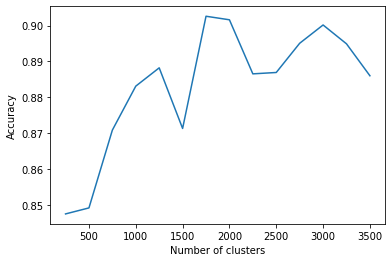

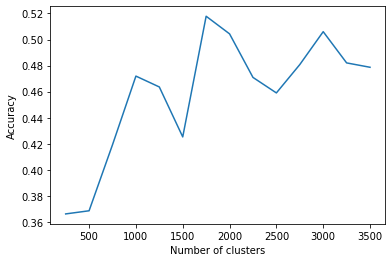

In [ ]:
average_acc = 0
average_f1 = 0

for seed in seed_list:
    average_acc += np.array(acc[seed])
    average_f1 += np.array(f1macro[seed])

average_acc /= len(seed_list)
average_f1 /= len(seed_list)

plt.plot(list_k, average_acc)
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy')
plt.show()

plt.plot(list_k, average_f1)
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
acc_full = 0.
f1_full = 0.
for seed in seed_list:
    y_pred = df_to_y_pred(df_train, df_test, seed)
    metrics = get_metrics(y_pred, df_test)
    acc_full += metrics[0]
    f1_full += metrics[2]
acc_full /= len(seed_list)
f1_full /= len(seed_list)

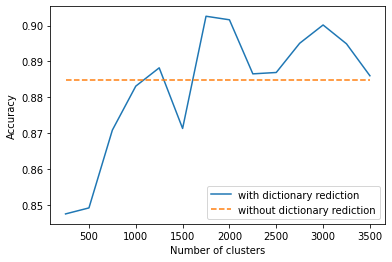

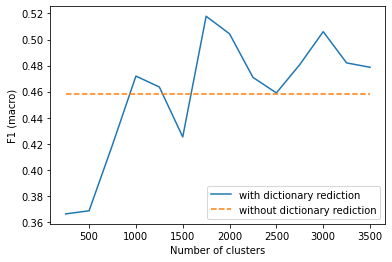

In [ ]:
average_acc = 0
average_f1 = 0

for seed in seed_list:
    average_acc += np.array(acc[seed])
    average_f1 += np.array(f1macro[seed])

average_acc /= len(seed_list)
average_f1 /= len(seed_list)

plt.plot(list_k, average_acc)
plt.plot([list_k[0], list_k[-1]], [acc_full, acc_full], '--')
plt.legend(['with dictionary rediction', 'without dictionary rediction'])
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy')
plt.show()

plt.plot(list_k, average_f1)
plt.plot([list_k[0], list_k[-1]], [f1_full, f1_full], '--')
plt.legend(['with dictionary rediction', 'without dictionary rediction'])
plt.xlabel('Number of clusters')
plt.ylabel('F1 (macro)')
plt.show()